In [1]:
import pandas as pd

In [2]:
import ast

In [3]:
import numpy as np

In [4]:
import seaborn as sns

In [5]:
import matplotlib.pyplot as plt

In [6]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [7]:
from sklearn.preprocessing import LabelEncoder

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
from sklearn.ensemble import RandomForestRegressor

In [10]:
from sklearn.metrics import mean_squared_error, r2_score, root_mean_squared_error

In [11]:
from sklearn.linear_model import LinearRegression

In [12]:
from sklearn.tree import DecisionTreeRegressor

In [13]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

In [14]:
def parse_json_column(column):
    return column.apply(ast.literal_eval)


def extract_keys_from_dict_list(dict_list):
    keys = set()
    for item in dict_list:
        keys.update(item.keys())
    return list(keys)


def flatten_json_data(df, column_name):
    data_list = []
    for item in df[column_name]:
        flattened_dict = {}
        for sub_dict in item["top"]:
            flattened_dict[sub_dict.get("key", "unknown_key")] = sub_dict.get(
                "value", None
            )
        data_list.append(flattened_dict)
    return pd.DataFrame(data_list)


def flatten_specs_data(df, column_name):
    data_list = []

    for item in df[column_name]:
        flattened_dict = {}

        for sub_dict in item.get("top", []):
            flattened_dict[sub_dict.get("key", "unknown_key")] = sub_dict.get(
                "value", None
            )

        for section in item.get("data", []):
            for sub_dict in section.get("list", []):
                column_key = (
                    f"{section['heading']}_{sub_dict.get('key', 'unknown_key')}"
                )
                flattened_dict[column_key] = sub_dict.get("value", None)

        data_list.append(flattened_dict)

    return pd.DataFrame(data_list)


def expand_data(df, location):

    df["new_car_detail"] = parse_json_column(df["new_car_detail"])
    df["new_car_overview"] = parse_json_column(df["new_car_overview"])
    df["new_car_feature"] = parse_json_column(df["new_car_feature"])
    df["new_car_specs"] = parse_json_column(df["new_car_specs"])

    df_detail = pd.json_normalize(df["new_car_detail"])
    df_overview = flatten_json_data(df, "new_car_overview")

    df_feature = df["new_car_feature"].apply(
        lambda x: {i: "Yes" for i in [item["value"] for item in x["top"]]}
    )
    df_feature = pd.json_normalize(df_feature)

    df_specs = flatten_specs_data(df, "new_car_specs")

    df_cleaned = pd.concat(
        [
            df.drop(
                [
                    "new_car_detail",
                    "new_car_overview",
                    "new_car_feature",
                    "new_car_specs",
                ],
                axis=1,
            ),
            df_detail,
            df_overview,
            df_feature,
            df_specs,
        ],
        axis=1,
    )

    df_cleaned["Location"] = location

    if df_cleaned.columns.duplicated().any():
        df_cleaned = df_cleaned.loc[:, ~df_cleaned.columns.duplicated()]

    return df_cleaned

In [15]:
bangalore_df = pd.read_excel(r"bangalore_cars.xlsx")
chennai_df = pd.read_excel(r"chennai_cars.xlsx")
delhi_df = pd.read_excel(r"delhi_cars.xlsx")
hyderabad_df = pd.read_excel(r"hyderabad_cars.xlsx")
jaipur_df = pd.read_excel(r"jaipur_cars.xlsx")
kolkata_df = pd.read_excel(r"kolkata_cars.xlsx")

bangalore_cleaned = expand_data(bangalore_df, "Bangalore")
chennai_cleaned = expand_data(chennai_df, "Chennai")
delhi_cleaned = expand_data(delhi_df, "Delhi")
hyderabad_cleaned = expand_data(hyderabad_df, "Hyderabad")
jaipur_cleaned = expand_data(jaipur_df, "Jaipur")
kolkata_cleaned = expand_data(kolkata_df, "Kolkata")

In [16]:
print(f"Number of columns in Bangalore: {bangalore_cleaned.shape[1]}")
print(f"Number of columns in Chennai: {chennai_cleaned.shape[1]}")
print(f"Number of columns in Delhi: {delhi_cleaned.shape[1]}")
print(f"Number of columns in Hyderabad: {hyderabad_cleaned.shape[1]}")
print(f"Number of columns in Jaipur: {jaipur_cleaned.shape[1]}")
print(f"Number of columns in Kolkata: {kolkata_cleaned.shape[1]}")

Number of columns in Bangalore: 123
Number of columns in Chennai: 121
Number of columns in Delhi: 131
Number of columns in Hyderabad: 126
Number of columns in Jaipur: 126
Number of columns in Kolkata: 122


In [17]:
combined_df = pd.concat(
    [
        bangalore_cleaned,
        chennai_cleaned,
        delhi_cleaned,
        hyderabad_cleaned,
        jaipur_cleaned,
        kolkata_cleaned,
    ],
    axis=0,
    ignore_index=True,
)

cols = combined_df.columns.tolist()
cols.remove("Location")
cols.append("Location")
combined_df = combined_df[cols]


In [18]:
# List of columns to check
columns_to_check = [
    'Power Steering', 'Power Windows Front', 'Air Conditioner', 'Heater',
    'Adjustable Head Lights', 'Manually Adjustable Exterior Rear View Mirror',
    'Centeral Locking', 'Child Safety Locks', 'Fog Lights Front',
    'Anti Lock Braking System', 'Cd Player', 'Radio',
    'Power Adjustable Exterior Rear View Mirror', 'Brake Assist',
    'Electric Folding Rear View Mirror', 'Power Door Locks',
    'Cd Changer', 'Fog Lights Rear', 'Remote Trunk Opener', 'Tinted Glass',
    'Halogen Headlamps', 'Usb Auxiliary Input', 'Passenger Side Rear View Mirror',
    'Cassette Player', 'Day Night Rear View Mirror', 'Power Windows Rear',
    'Leather Seats', 'Leather Steering Wheel', 'Rear Seat Belts',
    'Remote Fuel Lid Opener', 'Bluetooth', 'Speakers Front', 'Power Antenna',
    'Dvd Player', 'Audio System Remote Control', 'Wheel Covers',
    'Rear Window Wiper', 'Driver Air Bag', 'Low Fuel Warning Light',
    'Cup Holders Front', 'Navigation System', 'Tachometer', 'Glove Compartment',
    'Integrated2Din Audio', 'Digital Odometer', 'Fabric Upholstery',
    'Accessory Power Outlet', 'Rear Seat Headrest', 'Speakers Rear',
    'Adjustable Steering', 'Anti Theft Alarm', 'Number Of Speaker'
]

# Calculate the count of non-null values
features_series = combined_df[columns_to_check].notnull().sum(axis=1)

# Combine this with the original DataFrame using pd.concat
combined_df = pd.concat([combined_df.drop(columns=columns_to_check), features_series.rename('features')], axis=1)

In [19]:
interior_columns = [
    'Miscellaneous_Seating Capacity', 'Miscellaneous_Steering Type', 'Miscellaneous_Turning Radius',
    'Air Quality Control', 'Electronic Multi Tripmeter', 'Trunk Light', 'Vanity Mirror',
    'Rear Window Defogger', 'Adjustable Seats', 'Tyre Pressure Monitor', 'Touch Screen',
    'Integrated Antenna', 'Multifunction Steering Wheel', 'Sun Roof', 'Moon Roof',
    'Side Air Bag Front', 'Cruise Control', 'Drive Modes', 'Digital Clock',
    'Passenger Air Bag', 'Rear Folding Table', 'Driving Experience Control Eco'
]

# Calculate the count of non-null values for interior features
interior_series = combined_df[interior_columns].notnull().sum(axis=1)

# Add this as a new column
combined_df = pd.concat([combined_df.drop(columns=interior_columns), interior_series.rename('interior')], axis=1)

In [20]:
exterior_columns = [
    'Engine and Transmission_Engine Type', 'Engine and Transmission_Displacement',
    'Engine and Transmission_Max Power', 'Engine and Transmission_Max Torque',
    'Engine and Transmission_No of Cylinder', 'Engine and Transmission_Values per Cylinder',
    'Engine and Transmission_Value Configuration', 'Engine and Transmission_Fuel Suppy System',
    'Engine and Transmission_BoreX Stroke', 'Engine and Transmission_Compression Ratio',
    'Engine and Transmission_Turbo Charger', 'Engine and Transmission_Super Charger',
    'Dimensions & Capacity_Length', 'Dimensions & Capacity_Width',
    'Dimensions & Capacity_Height', 'Dimensions & Capacity_Wheel Base',
    'Dimensions & Capacity_Front Tread', 'Dimensions & Capacity_Rear Tread',
    'Dimensions & Capacity_Kerb Weight', 'Dimensions & Capacity_Gross Weight',
    'Miscellaneous_Gear Box', 'Miscellaneous_Drive Type', 'Miscellaneous_Front Brake Type',
    'Miscellaneous_Rear Brake Type', 'Miscellaneous_Top Speed', 'Miscellaneous_Acceleration',
    'Miscellaneous_Tyre Type', 'Miscellaneous_No Door Numbers', 'Miscellaneous_Cargo Volumn',
    'Wheel Size', 'Miscellaneous_Alloy Wheel Size', 'Dimensions & Capacity_Ground Clearance Unladen',
    'Rear Spoiler', 'Alloy Wheels', 'LEDDRLs'
]

# Calculate the count of non-null values for exterior features
exterior_series = combined_df[exterior_columns].notnull().sum(axis=1)

# Add this as a new column
combined_df = pd.concat([combined_df.drop(columns=exterior_columns), exterior_series.rename('exterior')], axis=1)

In [21]:
len(combined_df.columns)

40

In [22]:
# Drop multiple columns by name
combined_df = combined_df.drop(columns=['car_links', 'it', 'ft','owner','centralVariantId','priceActual','priceSaving','priceFixedText','trendingText.imgUrl','trendingText.heading','trendingText.desc','Registration Year','Kms Driven','RTO','Ownership','Transmission','Engine','Engine Immobilizer'])
combined_df

,bt,km,transmission,ownerNo,oem,model,modelYear,variantName,price,Insurance Validity,...,Engine Displacement,Year of Manufacture,Mileage,Max Power,Torque,Engine and Transmission_Color,Location,features,interior,exterior
0,Hatchback,"1,20,000",Manual,3,Maruti,Maruti Celerio,2015,VXI,₹ 4 Lakh,Third Party insurance,...,998 cc,2015.0,23.1 kmpl,67.04bhp,90Nm,White,Bangalore,8,3,29
1,SUV,"32,706",Manual,2,Ford,Ford Ecosport,2018,1.5 Petrol Titanium BSIV,₹ 8.11 Lakh,Comprehensive,...,1497 cc,2018.0,17 kmpl,121.31bhp,150Nm,White,Bangalore,9,3,27
2,Hatchback,"11,949",Manual,1,Tata,Tata Tiago,2018,1.2 Revotron XZ,₹ 5.85 Lakh,Comprehensive,...,1199 cc,2018.0,23.84 kmpl,84bhp,114Nm,Red,Bangalore,9,3,30
3,Sedan,"17,794",Manual,1,Hyundai,Hyundai Xcent,2014,1.2 Kappa S Option,₹ 4.62 Lakh,Comprehensive,...,1197 cc,2014.0,19.1 kmpl,81.86bhp,113.75Nm,Others,Bangalore,9,3,28
4,SUV,"60,000",Manual,1,Maruti,Maruti SX4 S Cross,2015,DDiS 200 Zeta,₹ 7.90 Lakh,Third Party insurance,...,1248 cc,2015.0,23.65 kmpl,88.5bhp,200Nm,Gray,Bangalore,9,3,27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8364,Hatchback,"10,000",Manual,1,Maruti,Maruti Celerio,2022,ZXI BSVI,₹ 5.10 Lakh,Third Party insurance,...,998 cc,2022.0,25.24 kmpl,65.71bhp,89Nm,Others,Kolkata,9,2,20
8365,Hatchback,"1,20,000",Manual,1,Maruti,Maruti Alto 800,2014,LXI,₹ 1.80 Lakh,Third Party insurance,...,796 cc,2014.0,22.74 kmpl,47.3bhp,69Nm,Others,Kolkata,8,3,27
8366,Sedan,"50,000",Automatic,3,Mercedes-Benz,Mercedes-Benz C-Class,2011,C 200 CGI Elegance,₹ 5.50 Lakh,Third Party insurance,...,1796 cc,2011.0,11.74 kmpl,186bhp,285Nm,Others,Kolkata,9,3,29
8367,Hatchback,"40,000",Manual,1,Maruti,Maruti Ritz,2012,ZXi,₹ 1.40 Lakh,Third Party insurance,...,1197 cc,2012.0,18.5 kmpl,85.80bhp,114Nm,Others,Kolkata,9,3,29


In [45]:
def clean_and_convert_column(df, column, dtype, remove_chars=None, unit=None, multiply_factor=1):
    if column in df.columns:
        # Convert to string to handle different data formats
        df[column] = df[column].astype(str)
        # Remove unwanted characters
        if remove_chars:
            for char in remove_chars:
                df[column] = df[column].replace(char, '', regex=True)
        # Remove units if specified
        if unit:
            df[column] = df[column].str.replace(unit, '', regex=True)
        # Convert to numeric
        df[column] = pd.to_numeric(df[column], errors='coerce') * multiply_factor
        # Fill missing values before converting to integer
        df[column] = df[column].fillna(0)
        # Convert to the specified data type
        if dtype == 'float':
            df[column] = df[column].astype(float)
        else:
            df[column] = df[column].astype(int)

# Clean and convert specified columns
# For 'price', handle multiplication to convert 'Lakh' to numbers
clean_and_convert_column(combined_df, 'price', 'int', remove_chars=['₹', ','], unit='Lakh', multiply_factor=100000)
clean_and_convert_column(combined_df, 'Seats', 'int', remove_chars=[' Seats'])
clean_and_convert_column(combined_df, 'Engine Displacement', 'int', remove_chars=[' cc'])
clean_and_convert_column(combined_df, 'Mileage', 'float', remove_chars=[' kmpl'])
clean_and_convert_column(combined_df, 'Max Power', 'float', remove_chars=['bhp'])
clean_and_convert_column(combined_df, 'Torque', 'int', remove_chars=['Nm'])

# Clean 'km' column by removing commas and converting to int
if 'km' in combined_df.columns:
    combined_df['km'] = combined_df['km'].replace(',', '', regex=True).astype(int)

# Handle 'Year of Manufacture' to remove decimals
if 'Year of Manufacture' in combined_df.columns:
    combined_df['Year of Manufacture'] = combined_df['Year of Manufacture'].fillna(0).astype(int)

combined_df

,bt,km,transmission,ownerNo,oem,model,modelYear,variantName,price,Insurance Validity,...,Engine Displacement,Year of Manufacture,Mileage,Max Power,Torque,Engine and Transmission_Color,Location,features,interior,exterior
0,Hatchback,120000,Manual,3,Maruti,Maruti Celerio,2015,VXI,400000,Third Party insurance,...,998,2015,23.10,67.04,90,White,Bangalore,8,3,29
1,SUV,32706,Manual,2,Ford,Ford Ecosport,2018,1.5 Petrol Titanium BSIV,811000,Comprehensive,...,1497,2018,17.00,121.31,150,White,Bangalore,9,3,27
2,Hatchback,11949,Manual,1,Tata,Tata Tiago,2018,1.2 Revotron XZ,585000,Comprehensive,...,1199,2018,23.84,84.00,114,Red,Bangalore,9,3,30
3,Sedan,17794,Manual,1,Hyundai,Hyundai Xcent,2014,1.2 Kappa S Option,462000,Comprehensive,...,1197,2014,19.10,81.86,113,Others,Bangalore,9,3,28
4,SUV,60000,Manual,1,Maruti,Maruti SX4 S Cross,2015,DDiS 200 Zeta,790000,Third Party insurance,...,1248,2015,23.65,88.50,200,Gray,Bangalore,9,3,27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8364,Hatchback,10000,Manual,1,Maruti,Maruti Celerio,2022,ZXI BSVI,509999,Third Party insurance,...,998,2022,25.24,65.71,89,Others,Kolkata,9,2,20
8365,Hatchback,120000,Manual,1,Maruti,Maruti Alto 800,2014,LXI,180000,Third Party insurance,...,796,2014,22.74,47.30,69,Others,Kolkata,8,3,27
8366,Sedan,50000,Automatic,3,Mercedes-Benz,Mercedes-Benz C-Class,2011,C 200 CGI Elegance,550000,Third Party insurance,...,1796,2011,11.74,186.00,285,Others,Kolkata,9,3,29
8367,Hatchback,40000,Manual,1,Maruti,Maruti Ritz,2012,ZXi,140000,Third Party insurance,...,1197,2012,18.50,85.80,114,Others,Kolkata,9,3,29


In [55]:
# Define the new column names
new_column_names = {
    'bt': 'Body_type',
    'km': 'Kilometer_Driven',
    'transmission': 'Transmission',
    'ownerNo': 'Owner_No.',
    'oem': 'Original_equipment_manufacturer',
    'model': 'Model',
    'modelYear': 'Model_year',
    'variantName': 'Variant_name',
    'price': 'Price',
    'Insurance Validity': 'Insurance_validity',
    'Fuel Type': 'Fuel_type',
    'Engine Displacement': 'Engine_displacement',
    'Year of Manufacture': 'Year_of_manufacture',
    'Mileage': 'Mileage',
    'Max Power': 'Max_power',
    'Torque': 'Torque',
    'Engine and Transmission_Color': 'Colour',
    'features': 'Features',
    'interior': 'Interior',
    'exterior': 'Exterior'
}

# Rename the columns in the DataFrame
combined_df.rename(columns=new_column_names, inplace=True)

combined_df['Price']

0       400000
1       811000
2       585000
3       462000
4       790000
         ...  
8364    509999
8365    180000
8366    550000
8367    140000
8368    500000
Name: Price, Length: 8369, dtype: int32

In [59]:
# Assuming 'combined_df' contains your training data

scaler_2 = MinMaxScaler()

# Fit the scaler to your training data
scaler_2.fit(combined_df[['Price']])

# Transform the training data (optional, but usually done)
combined_df['Price'] = scaler_2.transform(combined_df[['Price']])
combined_df

,Body_type,Kilometer_Driven,Transmission,Owner_No.,Original_equipment_manufacturer,Model,Model_year,Variant_name,Price,Insurance_validity,...,Engine_displacement,Year_of_manufacture,Mileage,Max_power,Torque,Colour,Location,Features,Interior,Exterior
0,Hatchback,120000,Manual,3,Maruti,Maruti Celerio,2015,VXI,0.515874,Third Party insurance,...,998,2015,23.10,67.04,90,White,Bangalore,8,3,29
1,SUV,32706,Manual,2,Ford,Ford Ecosport,2018,1.5 Petrol Titanium BSIV,0.515972,Comprehensive,...,1497,2018,17.00,121.31,150,White,Bangalore,9,3,27
2,Hatchback,11949,Manual,1,Tata,Tata Tiago,2018,1.2 Revotron XZ,0.515918,Comprehensive,...,1199,2018,23.84,84.00,114,Red,Bangalore,9,3,30
3,Sedan,17794,Manual,1,Hyundai,Hyundai Xcent,2014,1.2 Kappa S Option,0.515889,Comprehensive,...,1197,2014,19.10,81.86,113,Others,Bangalore,9,3,28
4,SUV,60000,Manual,1,Maruti,Maruti SX4 S Cross,2015,DDiS 200 Zeta,0.515967,Third Party insurance,...,1248,2015,23.65,88.50,200,Gray,Bangalore,9,3,27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8364,Hatchback,10000,Manual,1,Maruti,Maruti Celerio,2022,ZXI BSVI,0.515900,Third Party insurance,...,998,2022,25.24,65.71,89,Others,Kolkata,9,2,20
8365,Hatchback,120000,Manual,1,Maruti,Maruti Alto 800,2014,LXI,0.515821,Third Party insurance,...,796,2014,22.74,47.30,69,Others,Kolkata,8,3,27
8366,Sedan,50000,Automatic,3,Mercedes-Benz,Mercedes-Benz C-Class,2011,C 200 CGI Elegance,0.515910,Third Party insurance,...,1796,2011,11.74,186.00,285,Others,Kolkata,9,3,29
8367,Hatchback,40000,Manual,1,Maruti,Maruti Ritz,2012,ZXi,0.515811,Third Party insurance,...,1197,2012,18.50,85.80,114,Others,Kolkata,9,3,29


In [61]:
combined_df.to_csv("finalcombined_cars.csv", index=False)

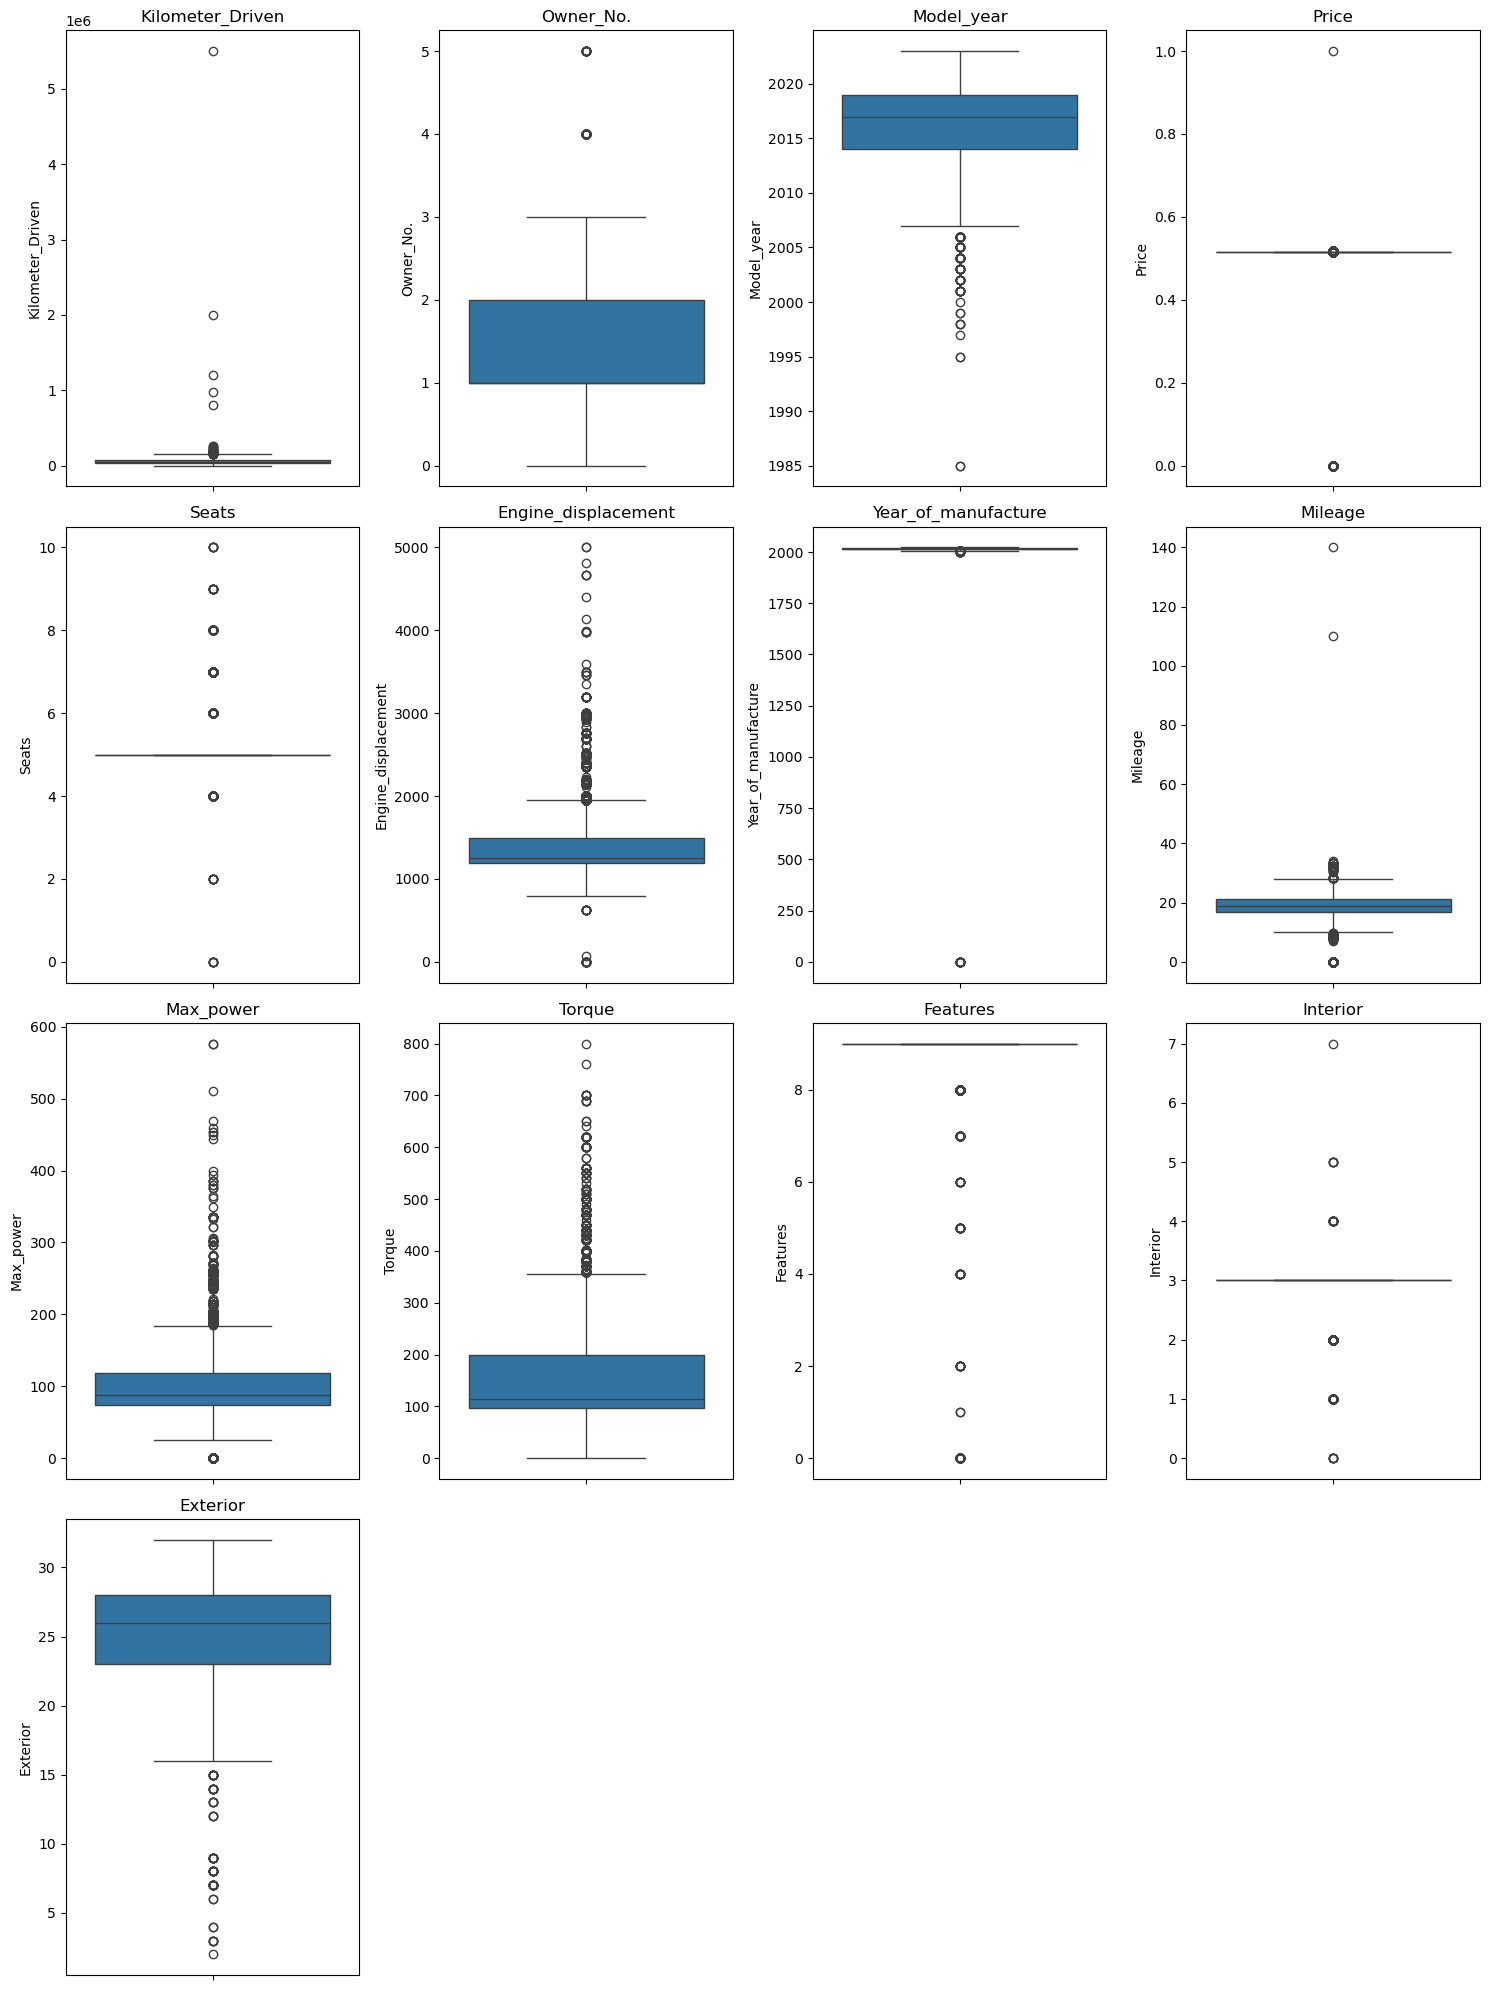

In [28]:
#seeing if outliers are present 
def plot_boxplots(combined_df, columns):
    num_cols = len(columns)
    num_rows = int(np.ceil(num_cols / 4))  # Adjust number of rows based on number of columns
    num_cols_subplot = min(num_cols, 4)  # Ensure at most 4 columns per row
    plt.figure(figsize=(15, 5 * num_rows))  # Adjust figure size based on number of rows
    
    for i, column in enumerate(columns):
        plt.subplot(num_rows, num_cols_subplot, i + 1)  # Adjust subplot grid
        sns.boxplot(combined_df[column])
        plt.title(column)
    
    plt.tight_layout()
    plt.show()

# Example usage
numerical_cols = combined_df.select_dtypes(include=['float', 'int']).columns
plot_boxplots(combined_df, numerical_cols)


In [63]:
#  Descriptive Statistics

# Assuming combined_df is your DataFrame with numerical columns

# Descriptive Statistics function
def descriptive_statistics(df):
    stats = pd.DataFrame({
        'Mean': df.mean(),
        'Median': df.median(),
        'Mode': df.mode().iloc[0],
        'Std Dev': df.std(),
        'Min': df.min(),
        'Max': df.max()
    })
    return stats

# Apply to numerical columns
numerical_cols = combined_df.select_dtypes(include=['float', 'int']).columns
stats_df = descriptive_statistics(combined_df[numerical_cols])

# Print the statistics
print("Descriptive Statistics:\n")
print(stats_df)


Descriptive Statistics:

                             Mean        Median      Mode       Std Dev  \
Kilometer_Driven     58974.302426  53692.000000  120000.0  74060.999945   
Owner_No.                1.360139      1.000000       1.0      0.641958   
Model_year            2016.503286   2017.000000    2018.0      3.921465   
Price                    0.509337      0.515922       0.0      0.058753   
Seats                    5.199546      5.000000       5.0      0.678011   
Engine_displacement   1424.054965   1248.000000    1197.0    478.529403   
Year_of_manufacture   2011.728761   2017.000000    2018.0     98.541131   
Mileage                 18.473264     18.900000       0.0      5.379348   
Max_power              102.170531     88.500000      88.5     49.005189   
Torque                 161.066794    115.000000       0.0    118.179108   
Features                 8.778229      9.000000       9.0      0.927743   
Interior                 2.783845      3.000000       3.0      0.450989   


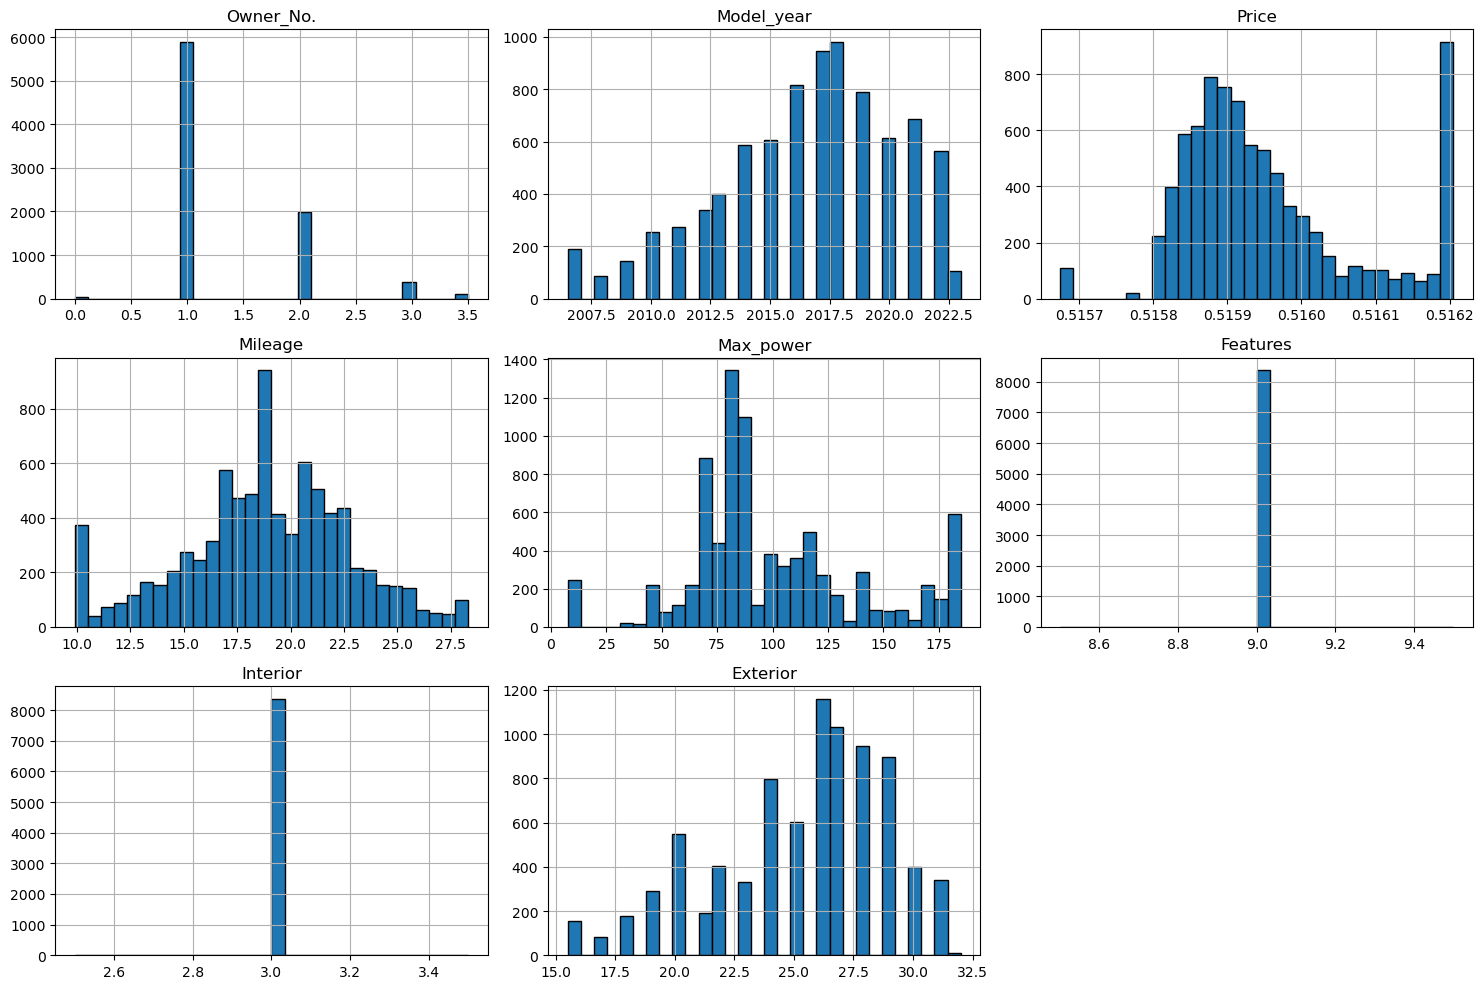

Skipping box plot for Features due to limited variance.
Skipping box plot for Interior due to limited variance.


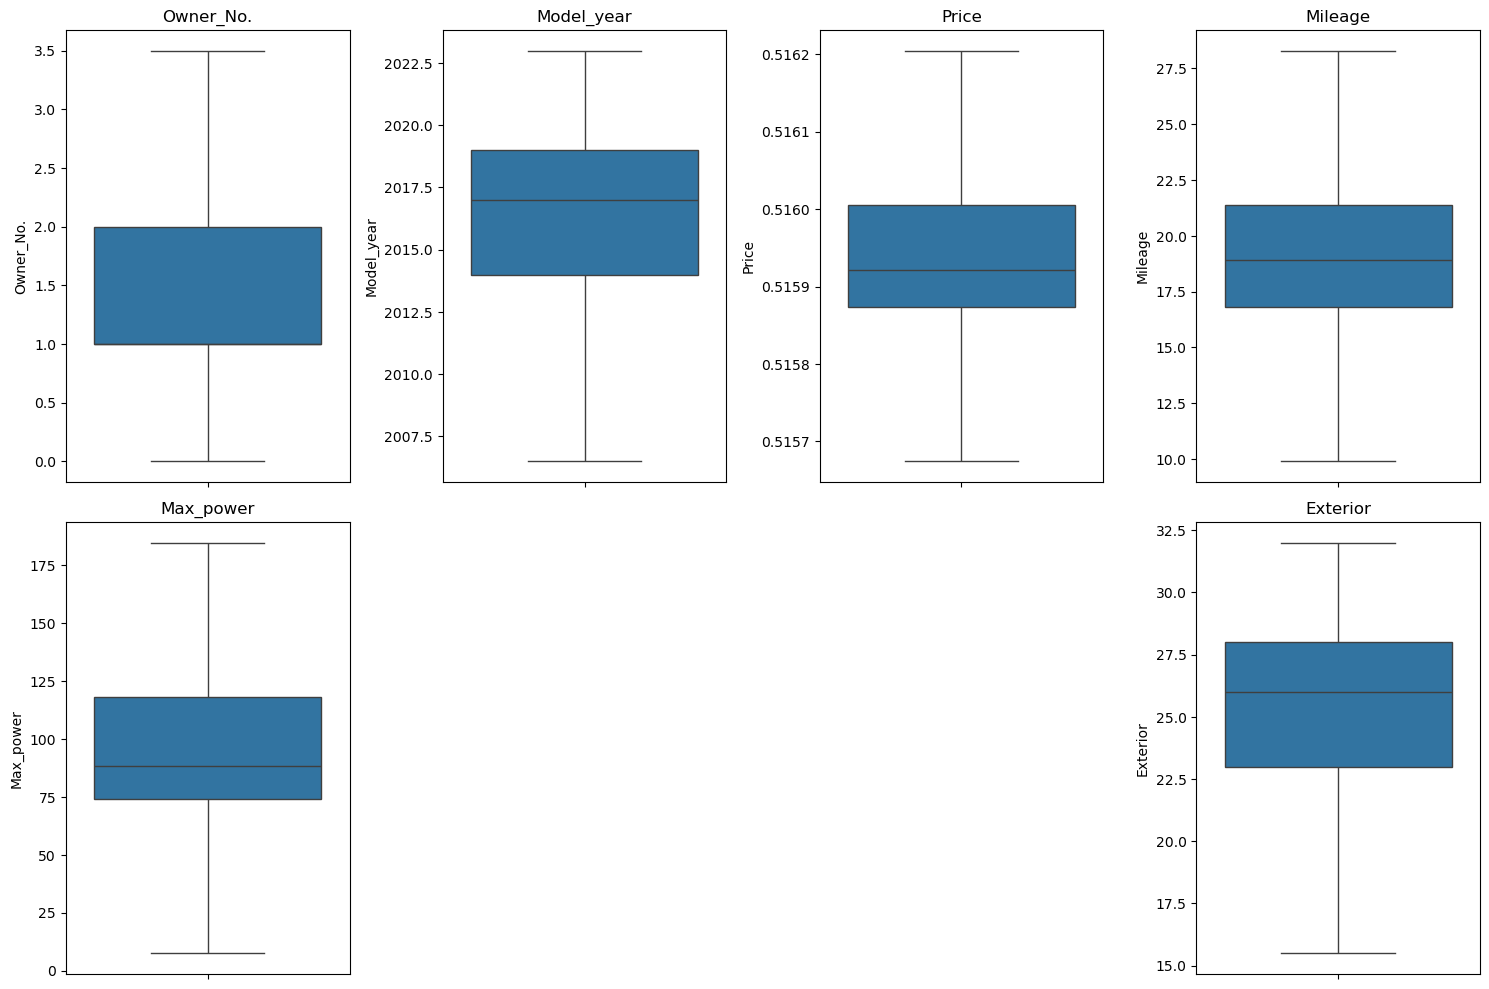

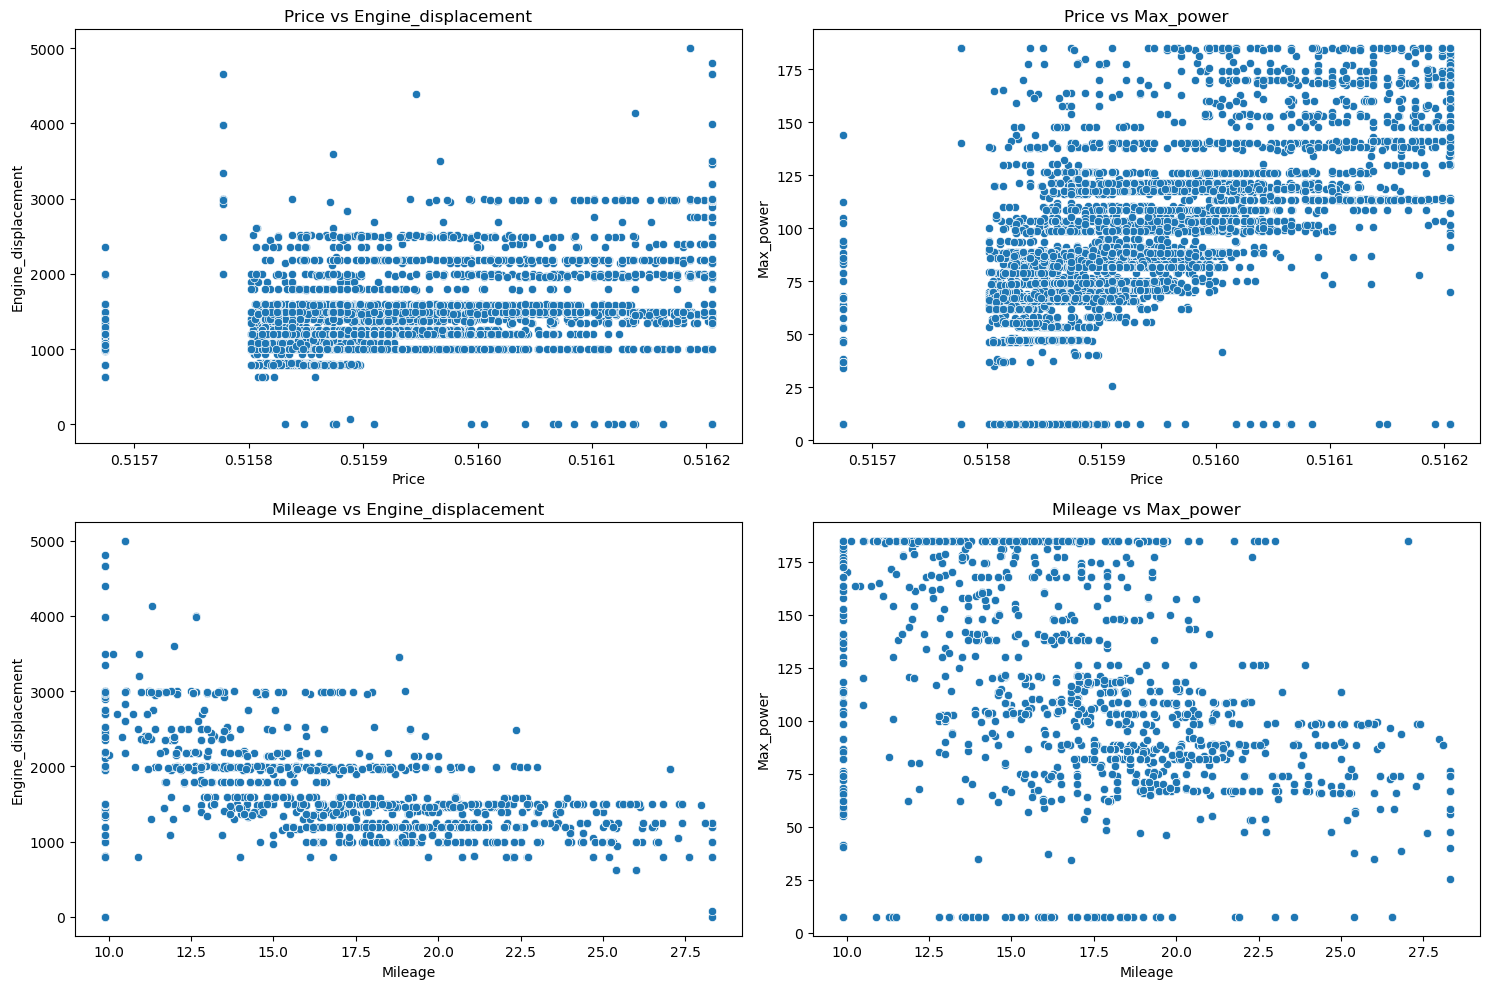

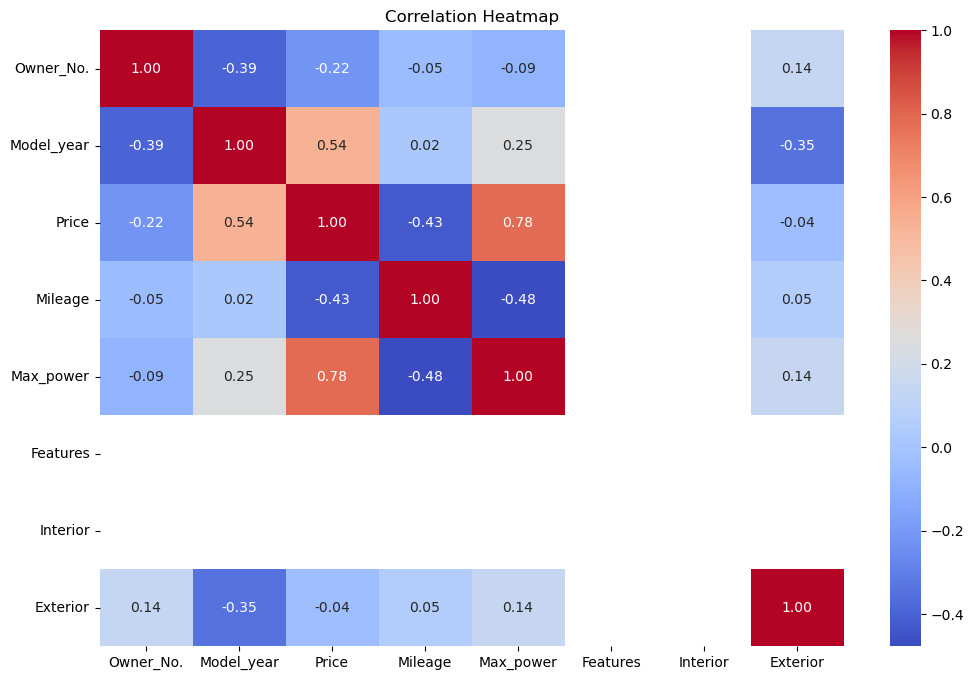

In [65]:
# Data Visualization

# Function to cap outliers using IQR
def cap_outliers_iqr(combined_df, columns):
    for col in columns:
        Q1 = combined_df[col].quantile(0.25)
        Q3 = combined_df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        combined_df[col] = np.clip(combined_df[col], lower_bound, upper_bound)
    return combined_df

# Histogram for numerical features
def plot_histograms(combined_df, columns):
    combined_df[columns].hist(figsize=(15, 10), bins=30, edgecolor='black')
    plt.tight_layout()
    plt.show()

# Box plots to identify outliers
def plot_boxplots(combined_df, columns):
    num_cols = len(columns)
    num_rows = int(np.ceil(num_cols / 4))  # Adjust number of rows based on number of columns
    num_cols_subplot = min(num_cols, 4)  # Ensure at most 4 columns per row
    plt.figure(figsize=(15, 5 * num_rows))  # Adjust figure size based on number of rows
   
    for i, column in enumerate(columns):
        if combined_df[column].nunique() > 1:  # Skip columns with a single unique value
            plt.subplot(num_rows, num_cols_subplot, i + 1)  # Adjust subplot grid
            sns.boxplot(data=combined_df[column])
            plt.title(column)
        else:
            print(f"Skipping box plot for {column} due to limited variance.")
   
    plt.tight_layout()
    plt.show()

# Scatter plots for feature relationships
def plot_scatter_plots(combined_df, x_cols, y_cols):
    plt.figure(figsize=(15, 10))
    for i, x in enumerate(x_cols):
        for j, y in enumerate(y_cols):
            plt.subplot(len(x_cols), len(y_cols), i*len(y_cols) + j + 1)
            sns.scatterplot(data=combined_df, x=x, y=y)
            plt.title(f'{x} vs {y}')
    plt.tight_layout()
    plt.show()

# Correlation heatmap
def plot_correlation_heatmap_fix(combined_df):
    # Select only numeric columns
    numeric_df = combined_df.select_dtypes(include=['float64', 'int64'])
   
    # Remove columns with only NaN values after capping outliers
    numeric_df = numeric_df.dropna(axis=1, how='all')
   
    plt.figure(figsize=(12, 8))
    correlation_matrix = numeric_df.corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Correlation Heatmap')
    plt.show()

# Example usage
numeric_cols = combined_df.select_dtypes(include=['float64', 'int64']).columns

# Filter columns with a single unique value or low variability
cols_to_plot = [col for col in numeric_cols if combined_df[col].nunique() > 1 and combined_df[col].std() > 0]

# Cap outliers before plotting
combined_df = cap_outliers_iqr(combined_df, cols_to_plot)

plot_histograms(combined_df, cols_to_plot)
plot_boxplots(combined_df, cols_to_plot)
plot_scatter_plots(combined_df, ['Price', 'Mileage'], ['Engine_displacement', 'Max_power'])
plot_correlation_heatmap_fix(combined_df[cols_to_plot])

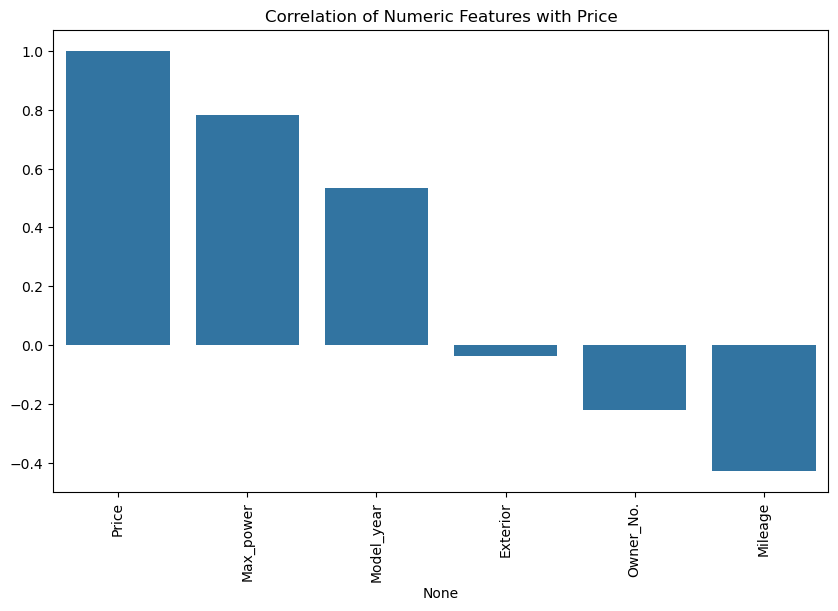

Features with high correlation with Price:
 Price         1.000000
Max_power     0.781756
Model_year    0.535235
Exterior     -0.036424
Owner_No.    -0.220044
Mileage      -0.427293
Name: Price, dtype: float64


In [69]:
# Correlation Analysis with the Target Variable Price
# For example, the feature Mileage has a correlation of -0.427, meaning that higher mileage tends to be associated with lower prices for used cars.
# Select only numeric columns for correlation calculation
numeric_cols = combined_df.select_dtypes(include=['float64', 'int64']).columns

# Exclude specific columns
numeric_cols = [col for col in numeric_cols if col not in ['Seats', 'Interior', 'Features']]

# Calculate correlation of all numeric features with the target variable 'Price'
correlation_matrix = combined_df[numeric_cols].corr()

# Extract correlation with 'Price'
correlation_with_price = correlation_matrix['Price'].sort_values(ascending=False)

# Plot the correlation values
plt.figure(figsize=(10, 6))
sns.barplot(x=correlation_with_price.index, y=correlation_with_price.values)
plt.xticks(rotation=90)
plt.title('Correlation of Numeric Features with Price')
plt.show()

# Print features with high correlation with Price
print("Features with high correlation with Price:\n", correlation_with_price)


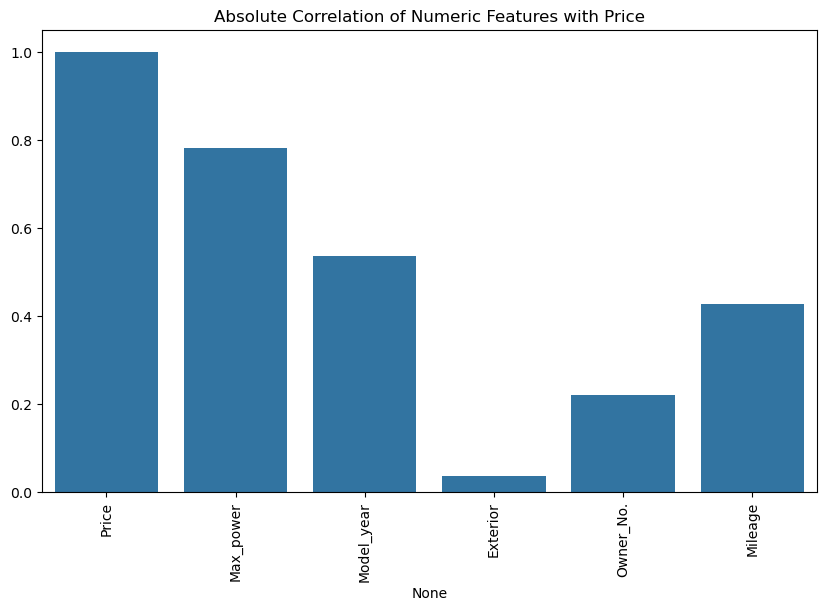

Features with high absolute correlation with Price:
 Price         1.000000
Max_power     0.781756
Model_year    0.535235
Exterior      0.036424
Owner_No.     0.220044
Mileage       0.427293
Name: Price, dtype: float64


In [71]:
# Convert correlation values to absolute for visualization
correlation_with_price_abs = np.abs(correlation_with_price)

# Plot the absolute correlation values
plt.figure(figsize=(10, 6))
sns.barplot(x=correlation_with_price_abs.index, y=correlation_with_price_abs.values)
plt.xticks(rotation=90)
plt.title('Absolute Correlation of Numeric Features with Price')
plt.show()

# Print features with high absolute correlation with Price
print("Features with high absolute correlation with Price:\n", correlation_with_price_abs)


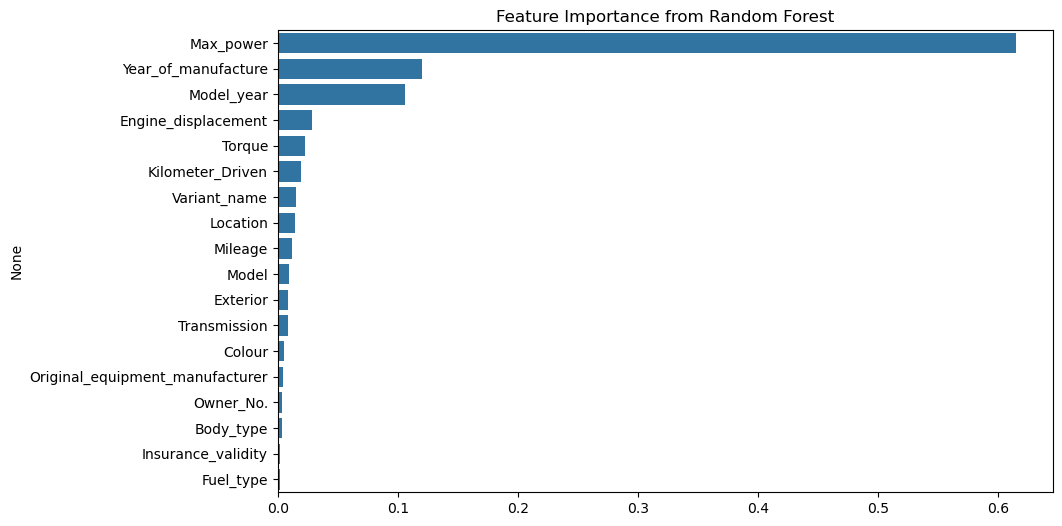

Top features based on importance:
 Max_power                          0.615106
Year_of_manufacture                0.120479
Model_year                         0.106113
Engine_displacement                0.028509
Torque                             0.022427
Kilometer_Driven                   0.019020
Variant_name                       0.015242
Location                           0.014108
Mileage                            0.011488
Model                              0.009615
Exterior                           0.008544
Transmission                       0.008440
Colour                             0.005190
Original_equipment_manufacturer    0.004406
Owner_No.                          0.003734
Body_type                          0.003446
Insurance_validity                 0.002253
Fuel_type                          0.001881
dtype: float64


In [73]:
# Step 2: Feature Importance using Random Forest

# Preprocessing: Encoding categorical features (use LabelEncoder for simplicity)
categorical_columns = combined_df.select_dtypes(include=['object']).columns
label_encoders = {}

for col in categorical_columns:
    le = LabelEncoder()
    combined_df[col] = le.fit_transform(combined_df[col].astype(str))
    label_encoders[col] = le

# Define features (X) and target (y)
X = combined_df.drop(['Price', 'Seats', 'Interior', 'Features'], axis=1)  # Exclude specific columns
y = combined_df['Price']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train a RandomForestRegressor model
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

# Calculate feature importance
feature_importance = pd.Series(rf_model.feature_importances_, index=X.columns).sort_values(ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importance.values, y=feature_importance.index)
plt.title('Feature Importance from Random Forest')
plt.show()

# Print the top features
print("Top features based on importance:\n", feature_importance)


In [75]:
# Step 3: Combine Correlation and Feature Importance Results
selected_features = [
    'Mileage', 'Engine_displacement', 'Year_of_manufacture',
    'Transmission', 'Fuel_type', 'Owner_No.', 
    'Model_year', 'Location', 'Kilometer_Driven', 'Body_type'
]

# Ensure the dataset contains only the selected features along with the target variable 'Price'
final_df = combined_df[selected_features + ['Price']]

# Display the final dataframe to verify
final_df.head()


,Mileage,Engine_displacement,Year_of_manufacture,Transmission,Fuel_type,Owner_No.,Model_year,Location,Kilometer_Driven,Body_type,Price
0,23.10,998,2015,1,4,3.0,2015.0,0,120000,3,0.515874
1,17.00,1497,2018,1,4,2.0,2018.0,0,32706,8,0.515972
2,23.84,1199,2018,1,4,1.0,2018.0,0,11949,3,0.515918
3,19.10,1197,2014,1,4,1.0,2014.0,0,17794,9,0.515889
4,23.65,1248,2015,1,1,1.0,2015.0,0,60000,8,0.515967


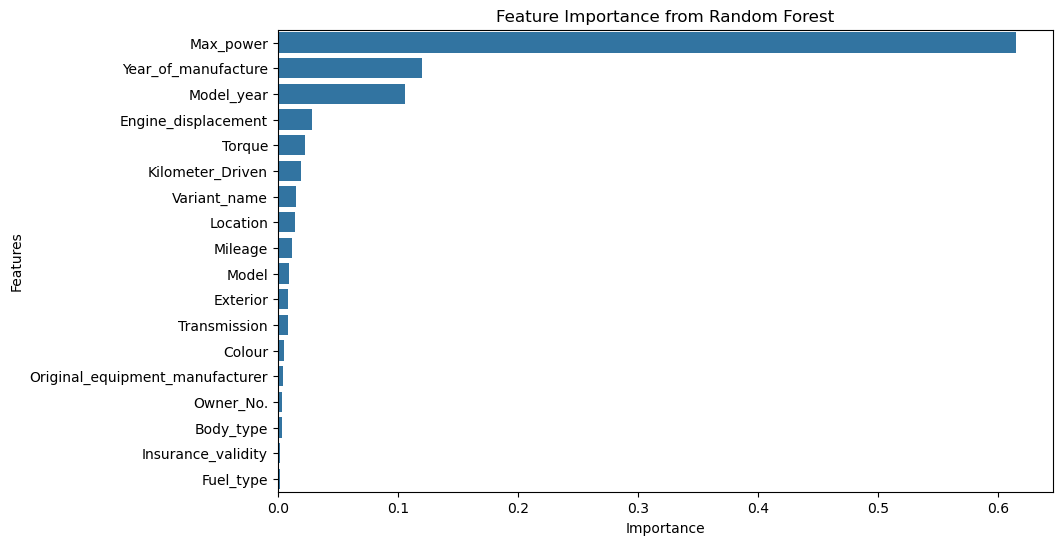

Top features based on importance:
 Max_power                          0.615106
Year_of_manufacture                0.120479
Model_year                         0.106113
Engine_displacement                0.028509
Torque                             0.022427
Kilometer_Driven                   0.019020
Variant_name                       0.015242
Location                           0.014108
Mileage                            0.011488
Model                              0.009615
Exterior                           0.008544
Transmission                       0.008440
Colour                             0.005190
Original_equipment_manufacturer    0.004406
Owner_No.                          0.003734
Body_type                          0.003446
Insurance_validity                 0.002253
Fuel_type                          0.001881
dtype: float64


In [77]:
# Calculate feature importance
feature_importance = pd.Series(rf_model.feature_importances_, index=X.columns).sort_values(ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importance.values, y=feature_importance.index)
plt.title('Feature Importance from Random Forest')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

# Print the top features
print("Top features based on importance:\n", feature_importance)


In [36]:
# Engine_displacement is the most important feature in predicting the price, as it has the highest importance score.
# Model_year and Year_of_manufacture are also quite significant.
# Features like Body_type and Mileage have moderate importance.
# Transmission, Kilometer_Driven, Location, Owner_No., and Fuel_type contribute less to the prediction.

In [79]:
#1. Train-Test Split
# Import necessary libraries

# Separate features (X) and target (y)
X = final_df.drop('Price', axis=1)
y = final_df['Price']

# Perform the train-test split (using 80-20 ratio here)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [81]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import root_mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split

# Assuming you have already defined X_train, X_test, y_train, y_test

# Dictionary to store models and their names
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor(),
    "Gradient Boosting": GradientBoostingRegressor()
}

for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Evaluation metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)  # Root MSE
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"--- {name} Results ---")  # Dynamically include the model name
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"Root Mean Squared Error (RMSE): {rmse}")
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"R-squared (R2): {r2}")
    print("-" * 30)

Training Linear Regression...
--- Linear Regression Results ---
Mean Squared Error (MSE): 3.979447260669537e-09
Root Mean Squared Error (RMSE): 6.308286027654055e-05
Mean Absolute Error (MAE): 4.381712888222723e-05
R-squared (R2): 0.7296331872704165
------------------------------
Training Decision Tree...
--- Decision Tree Results ---
Mean Squared Error (MSE): 2.400406995868436e-09
Root Mean Squared Error (RMSE): 4.899394856376077e-05
Mean Absolute Error (MAE): 2.6318326118568715e-05
R-squared (R2): 0.8369144390626874
------------------------------
Training Random Forest...


C:\Users\dilib\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\dilib\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\dilib\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


--- Random Forest Results ---
Mean Squared Error (MSE): 1.6878032917818584e-09
Root Mean Squared Error (RMSE): 4.108288319704276e-05
Mean Absolute Error (MAE): 2.154651201991239e-05
R-squared (R2): 0.885329301628492
------------------------------
Training Gradient Boosting...
--- Gradient Boosting Results ---
Mean Squared Error (MSE): 2.29268212407803e-09
Root Mean Squared Error (RMSE): 4.788196031991621e-05
Mean Absolute Error (MAE): 2.9055828311258676e-05
R-squared (R2): 0.8442333525523902
------------------------------


C:\Users\dilib\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [40]:
#Random Forest has the lowest MSE (1.69e-09), lowest RMSE (4.11e-05), and lowest MAE (2.15e-05). Additionally, it achieves the highest R² (0.8853), making it the best model overall.
#Decision Tree and Gradient Boosting also perform well but are slightly less accurate than Random Forest.
#Linear Regression has the weakest performance with the highest errors and lowest R².

In [85]:
best_rf_model = RandomForestRegressor(random_state=42)
best_rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [87]:
import joblib

joblib.dump(best_rf_model,'rf_trainedmodel.pkl')
joblib.dump(label_encoders,'label_encoders.pkl')
joblib.dump(scaler_2,'min.pkl')

['min.pkl']

In [97]:
import joblib

# --- Load the model and encoders (for later use) ---
loaded_model = joblib.load("rf_trainedmodel.pkl")
loaded_encoders = joblib.load("label_encoders.pkl")
loaded_scaler = joblib.load("min.pkl")

categorical_columns = [
    "Body_type",
    "Transmission",
    "Original_equipment_manufacturer",
    "Model",
    "Variant_name",
    "Insurance_validity",
    "Fuel_type",
    "Colour",
    "Location",
]


# --- Function to take custom inputs and predict price ---
def predict_price(
    mileage,
    engine_displacement,
    year_of_manufacture,
    transmission,
    fuel_type,
    owner_no,
    model_year,
    location,
    kilometer_driven,
    body_type,
):

    # Create a DataFrame from the input values
    input_data = pd.DataFrame(
        {
            "Mileage": [mileage],
            "Engine_displacement": [engine_displacement],
            "Year_of_manufacture": [year_of_manufacture],
            "Transmission": [transmission],
            "Fuel_type": [fuel_type],
            "Owner_No.": [owner_no],
            "Model_year": [model_year],
            "Location": [location],
            "Kilometer_Driven": [kilometer_driven],
            "Body_type": [body_type],
        }
    )

    # Encode categorical features using the loaded LabelEncoders
    for col in categorical_columns:
        if col not in {
            "Original_equipment_manufacturer",
            "Model",
            "Variant_name",
            "Insurance_validity",
            "Colour",
        }:
            le = loaded_encoders[col]
            input_data[col] = le.transform(input_data[col].astype(str))

    # Make the prediction
    predicted_price = loaded_model.predict(input_data)
    predicted_price_norm = loaded_scaler.inverse_transform([[predicted_price[0]]])[0][0]
    return predicted_price_norm



# --- Example usage (allowing user input) ---
mileage = float(input("Enter Mileage: "))
engine_displacement = float(input("Enter Engine Displacement: "))
year_of_manufacture = float(input("Enter Year of Manufacture: "))
transmission = input("Enter Transmission (e.g., Manual, Automatic): ")
fuel_type = input("Enter Fuel Type (e.g., Petrol, Diesel): ")
owner_no = float(input("Enter Owner No.: "))
model_year = float(input("Enter Model Year: "))


location = input(
    "Enter Location: "
)  # You might need to handle location input differently
kilometer_driven = float(input("Enter Kilometer Driven: "))
body_type = input(
    "Enter Body Type: "
)  # You might need to handle body type input differently



predicted_price = predict_price(
    mileage,
    engine_displacement,
    year_of_manufacture,
    transmission,
    fuel_type,
    owner_no,
    model_year,
    location,
    kilometer_driven,
    body_type,
)


print(f"Predicted Price: {predicted_price}")

Enter Mileage:  23
Enter Engine Displacement:  234
Enter Year of Manufacture:  2015
Enter Transmission (e.g., Manual, Automatic):  Manual
Enter Fuel Type (e.g., Petrol, Diesel):  Petrol
Enter Owner No.:  3
Enter Model Year:  2014
Enter Location:  Chennai
Enter Kilometer Driven:  4500
Enter Body Type:  SUV


Predicted Price: -57810.20000132926


In [99]:
# Example: Create a new feature 'Car_Age' using .loc to avoid SettingWithCopyWarning
final_df.loc[:, 'Car_Age'] = 2024 - final_df['Year_of_manufacture']

# Example: Create interaction terms
final_df.loc[:, 'Mileage_Displacement'] = final_df['Mileage'] * final_df['Engine_displacement']

# Check if columns exist before dropping
columns_to_drop = ['Price', 'Seats', 'Interior', 'Features']
existing_columns_to_drop = [col for col in columns_to_drop if col in final_df.columns]

# Re-train the Random Forest model with new features
X = final_df.drop(existing_columns_to_drop, axis=1)
y = final_df['Price']

# Train with the new features
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

C:\Users\dilib\AppData\Local\Temp\ipykernel_1724\719111358.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df.loc[:, 'Car_Age'] = 2024 - final_df['Year_of_manufacture']
C:\Users\dilib\AppData\Local\Temp\ipykernel_1724\719111358.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df.loc[:, 'Mileage_Displacement'] = final_df['Mileage'] * final_df['Engine_displacement']


RandomForestRegressor(random_state=42)

In [101]:
from sklearn.linear_model import Ridge, Lasso

# Ridge (L2) Regularization
ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)
ridge_pred = ridge.predict(X_test)
print(f"Ridge Regression MSE: {mean_squared_error(y_test, ridge_pred)}")

# Lasso (L1) Regularization
lasso = Lasso(alpha=0.1)
lasso.fit(X_train, y_train)
lasso_pred = lasso.predict(X_test)
print(f"Lasso Regression MSE: {mean_squared_error(y_test, lasso_pred)}")


Ridge Regression MSE: 3.7128895333357284e-09
Lasso Regression MSE: 1.5708320390562783e-08


In [103]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

# Define features and target
X = final_df.drop(['Price', 'Seats', 'Interior', 'Features'], axis=1, errors='ignore')
y = final_df['Price']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize models
models = {
    "Random Forest": RandomForestRegressor(random_state=42),
    "Ridge Regression": Ridge(alpha=1.0),
    "Lasso Regression": Lasso(alpha=0.1)
}

# Train and evaluate models
for name, model in models.items():
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    print(f"{name} MSE: {mse}")

Random Forest MSE: 1.6310131671477909e-09
Ridge Regression MSE: 3.7128895333357284e-09
Lasso Regression MSE: 1.5708320390562783e-08


In [105]:
import joblib

# Train and save the Ridge model
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train, y_train)
joblib.dump(ridge_model, 'ridge_model.pkl')

['ridge_model.pkl']